In [38]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Train data

In [10]:
display(train.head())

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1


### Test data

In [11]:
display(test.head())

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   16637 non-null  object 
 1   holiday     16637 non-null  int64  
 2   weathersit  16637 non-null  int64  
 3   temp        16637 non-null  float64
 4   atemp       16637 non-null  float64
 5   hum         16637 non-null  float64
 6   windspeed   16637 non-null  float64
 7   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


### Data Types

Er zijn verschillende data types aanwezig:
- **Object:** date_hour
- **Integer:** holiday, weathersit en cnt
- **Float:** temp, atemp, hum en windspeed

In [12]:
display(train.describe())

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


### Controle op Ontbrekende Waarden

In [18]:
print(train.isnull().sum())

date_hour     0
holiday       0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64


Alle kolommen in deze dataset hebben geen ontbrekende waarden. Dit betekent dat er geen ontbrekende data hoeft te worden aangevuld of verwijderd, wat de analyse eenvoudiger maakt.

### Vorm van de gegevens:

In [19]:
print(train.shape)

(16637, 8)


De dataset bevat 8 kolommen (variabelen) en 16.637 rijen.

### Kolommen beschrijven:

- **date_hour:** Datum en tijdstip.
- **holiday:** Geeft aan of de datum een feestdag is (0 = geen feestdag, 1 = feestdag).
- **weathersit:**  De beschrijving van de weersomstandigheden op een schaal van 1 tot 4.
- **temp:** De normale temperatuur
- **atemp:** 
- **hum:** Luchtvochtigheid
- **windspeed:** Windsnelheid
- **cnt:** 

### Het meetniveau voor elke kolom:

- **date_hour:** Interval 
- **holiday:** Nominaal (binaire categorische variabele: 0 = geen feestdag, 1 = feestdag).
- **weathersit:** Ordinaal (categorieën hebben een volgorde).
- **temp:** Interval (continue variabele).
- **atemp:** Interval (continue variabele).
- **hum:** Interval (continue variabele).
- **windspeed:** Interval (continue variabele).
- **cnt:** Ratio

Wij hebben de kolom date_hour omgezet naar een datetime-formaat om tijdsreeksanalyses mogelijk te maken. Wanneer date_hour als een datetime-object is opgeslagen, kunnen we eenvoudig tijdsgebonden analyses uitvoeren.

In [ ]:
# Converteer de kolom 'date_hour' naar datetime voor tijdreeksanalyse
train["date_hour"] = pd.to_datetime(train["date_hour"])

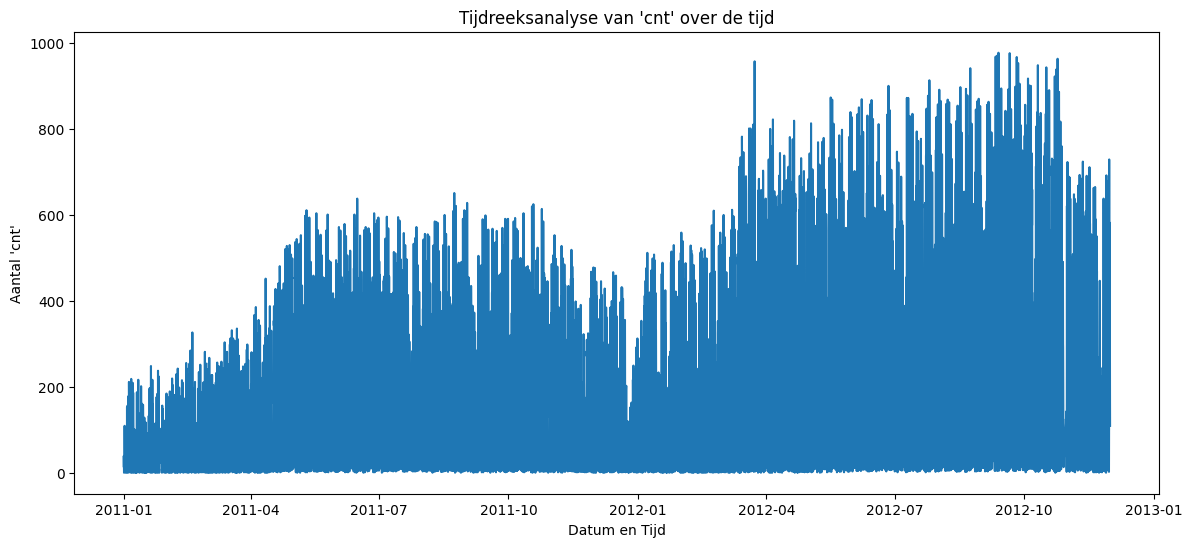

In [73]:
# Tijdreeksanalyse van 'cnt' over de tijd
plt.figure(figsize=(14, 6))
plt.plot(train["date_hour"], train["cnt"])
plt.title("Tijdreeksanalyse van 'cnt' over de tijd")
plt.xlabel("Datum en Tijd")
plt.ylabel("Aantal 'cnt'")
plt.show()

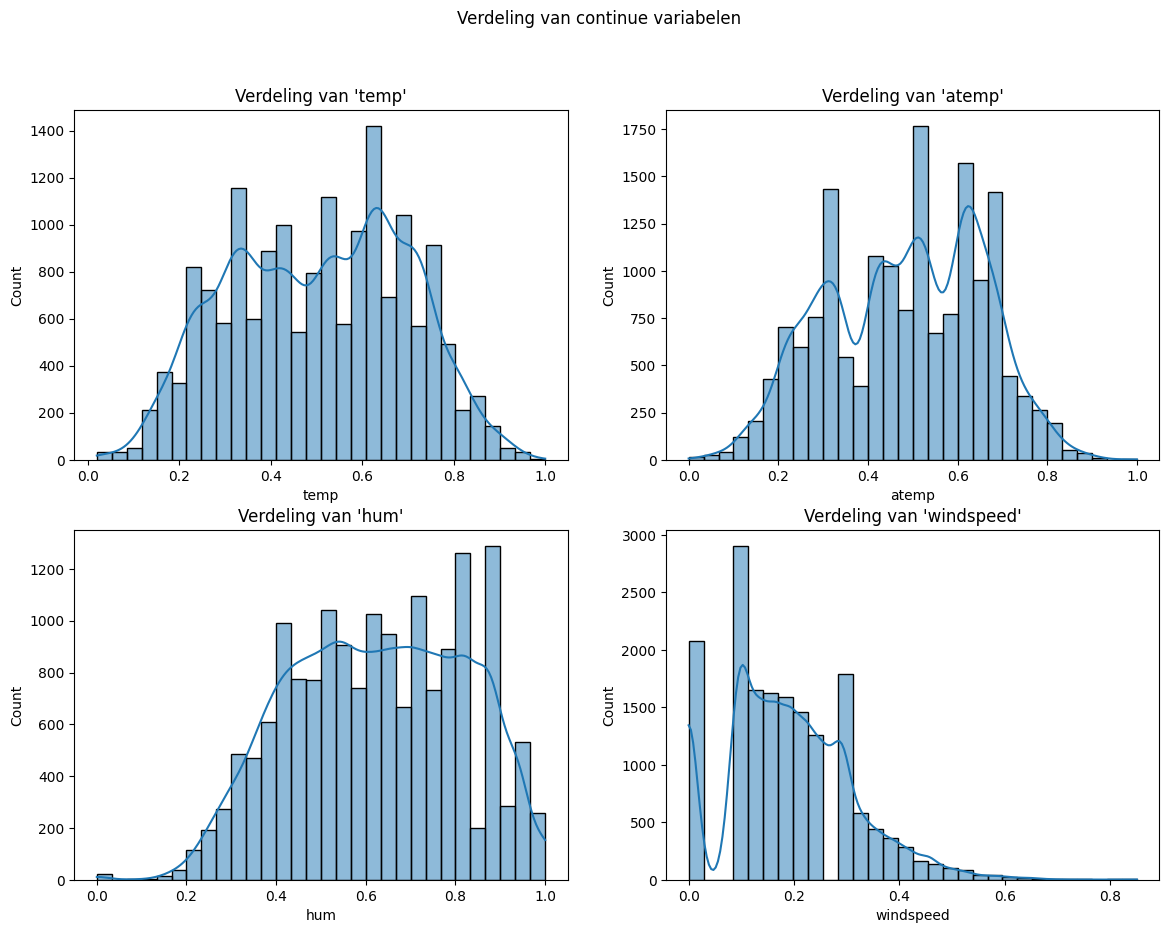

In [55]:
# Verdelingsplots van continue variabelen: 'temp', 'atemp', 'hum', 'windspeed'
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Verdeling van continue variabelen")

sns.histplot(train["temp"], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Verdeling van 'temp'")

sns.histplot(train["atemp"], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Verdeling van 'atemp'")

sns.histplot(train["hum"], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Verdeling van 'hum'")

sns.histplot(train["windspeed"], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Verdeling van 'windspeed'")

plt.show()

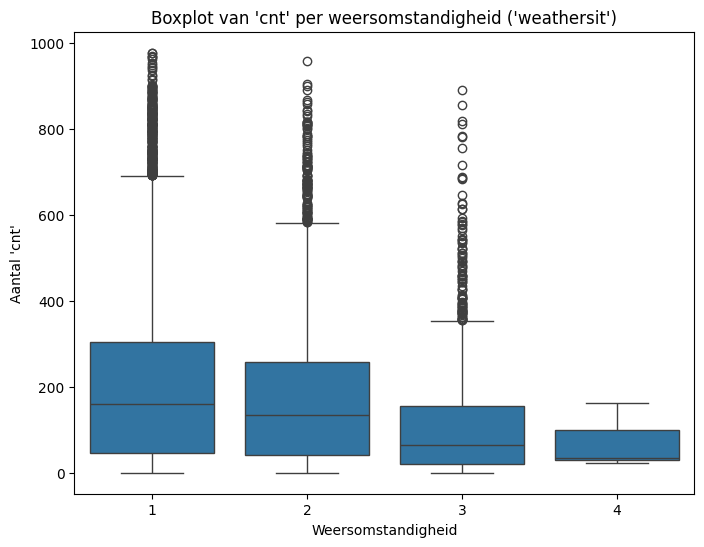

In [72]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="weathersit", y="cnt", data=train)
plt.title("Boxplot van 'cnt' per weersomstandigheid ('weathersit')")
plt.xlabel("Weersomstandigheid")
plt.ylabel("Aantal 'cnt'")
plt.show()

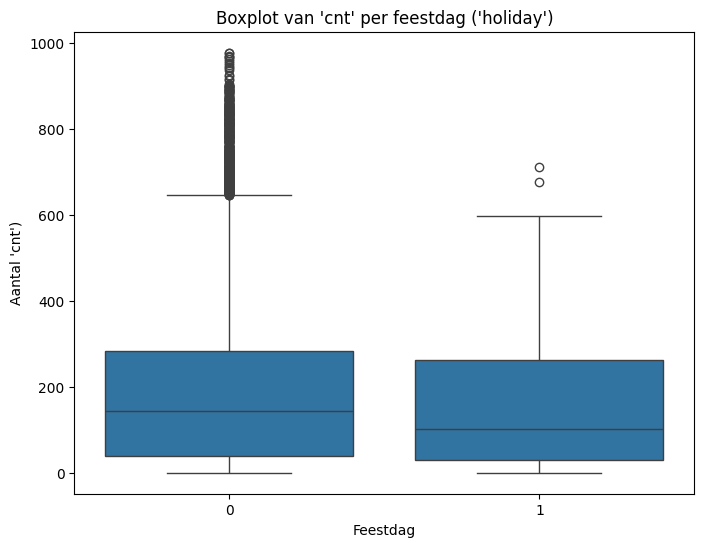

In [71]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="holiday", y="cnt", data=train)
plt.title("Boxplot van 'cnt' per feestdag ('holiday')")
plt.xlabel("Feestdag")
plt.ylabel("Aantal 'cnt')")
plt.show()

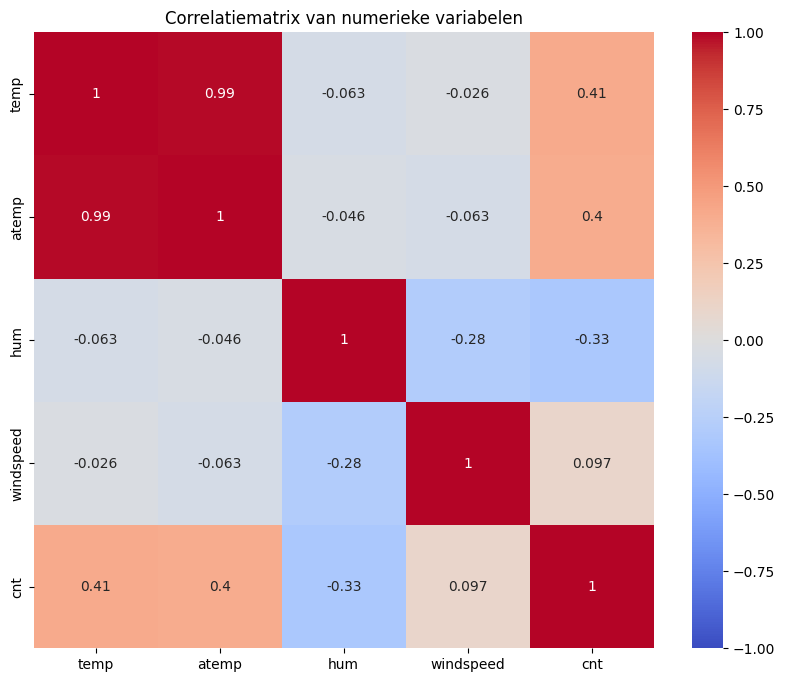

In [51]:
# Correlatiematrix van numerieke variabelen
plt.figure(figsize=(10, 8))
correlation_matrix = train[["temp", "atemp", "hum", "windspeed", "cnt"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlatiematrix van numerieke variabelen")
plt.show()

**Tijdreeksanalyse van cnt:**

- Het aantal cnt neemt in de loop van de tijd toe, met duidelijke schommelingen die mogelijk verband houden met seizoenen of andere tijdsgebonden factoren.

**Verdelingsplots van continue variabelen:**

- temp en atemp hebben een bijna normale verdeling, met een piek rond 0,6.
- hum heeft een vrij gelijkmatige verdeling, maar met een lichte piek bij hogere luchtvochtigheidswaarden.
- windspeed heeft een piek bij lagere waardes, wat suggereert dat de meeste cnt lage windsnelheden hebben.

**Boxplots van cnt per weersomstandigheid:**

- Het aantal cnt is het hoogst bij heldere weersomstandigheden en neemt af bij zwaardere weersomstandigheden. Dit suggereert dat slecht weer invloed kan hebben op de activiteit.

**Boxplots van cnt per feestdag (holiday):**

- Er zijn geen significante verschillen in cnt tussen feestdagen en gewone dagen, hoewel de variatie iets groter is op gewone dagen.

**Correlatiematrix:**

- temp en atemp zijn sterk gecorreleerd (0,99), wat logisch is omdat beide temperatuurgerelateerd zijn.
- temp en atemp vertonen een matige positieve correlatie met cnt, wat aangeeft dat hogere temperaturen mogelijk gepaard gaan met meer cnt.
- hum heeft een zwakke negatieve correlatie met cnt, wat kan betekenen dat hogere luchtvochtigheid  een negatieve invloed kan hebben op de cnt.
- temp en atemp vertonen vaak een matige positieve correlatie met cnt. Dit wijst erop dat hogere temperaturen kunnen leiden tot een toename in het aantal cnt.

### Controle op Uitschieters

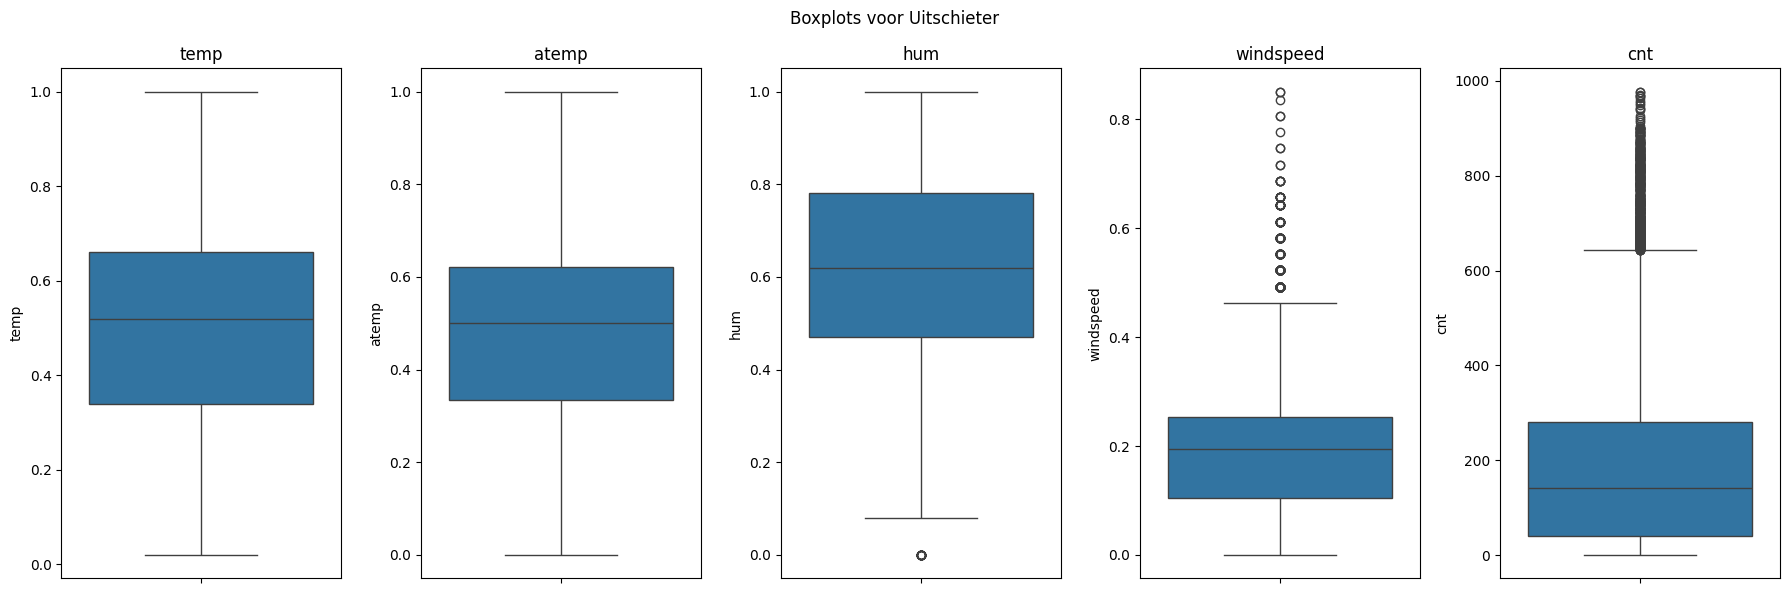

In [70]:
fig, axes = plt.subplots(1, 5, figsize=(18, 6))
fig.suptitle("Boxplots voor Uitschieter")

cols_names = ["temp", "atemp", "hum", "windspeed", "cnt"]
for i, col in enumerate(cols_names):
    sns.boxplot(y=train[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

- hum: Er zijn enkele waarden dicht bij de minimumdie als outliers kunnen worden beschouwd.
- windspeed : Er zijn een paar lage waarden die als uitschieters worden beschouwd.
- cnt: Er zijn een paar hoge waarden die buiten het interkwartielbereik liggen en als uitschieters kunnen worden gezien.

### **Lineaire Regressie**

Lineaire regressie is een wiskundige methode die gebruikt wordt om de relatie tussen twee variabelen te beschrijven met een rechte lijn. Deze lijn heeft de volgende vergelijking:
[(FasterCapital. (z.d.))](https://fastercapital.com/nl/inhoud/Lineaire-regressie--hoe-u-lineaire-regressie-kunt-gebruiken-voor-doorklikmodellering-en-hoe-u-de-lineaire-relatie-kunt-vastleggen.html)

$$y=a⋅x+b$$

Waarbij:

- $y$:  De afhankelijke variabele.
- $x$: De onafhankelijke variabele.
- $a$: De helling van de lijn, die laat zien hoe $y$ verandert als $x$ toeneemt.
- $b$: Het snijpunt van de lijn met de $y-as$(intercept).

Bij meer complexe datasets met meerdere onafhankelijke variabelen wordt de formule uitgebreid naar een multivariate vorm:

$$
y = a_1 \cdot x_1 + a_2 \cdot x_2 + \dots + a_n \cdot x_n + b
$$

Waarbij:

- $x_1, x_2, \dots, x_n$: De onafhankelijke variabelen.
- $a_1, a_2, \dots, a_n$: De hellingen.
- $b$: Het snijpunt van de lijn met de $y-as$(intercept).

Dit wordt vaak gebruikt in **meervoudige lineaire regressie** [(Tieleman (2023))](https://datasciencepartners.nl/linear-regression-assumptions/).

Het doel van lineaire regressie is om een verband te laten zien tussen twee soorten gegevens: een onafhankelijke variabele en een afhankelijke variabele. Dit gebeurt door een rechte lijn te maken die zo goed mogelijk bij de gegevens past. De lijn wordt zo gekozen dat het verschil tussen de echte waarden en de voorspelde waarden zo klein mogelijk is. Op deze manier laat de lijn zien hoe de gegevens samenhangen en wat de trend is.

#### **De Kleinste Kwadraten Methode(The Least Squares Method)**
De kleinste kwadraten methode berekent de lijn die de data het best past door de residuen te minimaliseren. Een residu is het verschil tussen de werkelijke waarde ($y_i$) en de voorspelde waarde ($y=a⋅x+b$). Deze verschillen worden gekwadrateerd en opgeteld, zoals weergegeven in de formule:

$$\sum_{i=1}^{n} \left( y_i - (a \cdot x_i + b) \right)^2$$


De lijn die ervoor zorgt dat de totale afwijking zo klein mogelijk is, wordt de beste lijn genoemd.

[(Wikipedia contributors, 2023)](https://en.wikipedia.org/wiki/Residual_sum_of_squares).

De helling ($a$) wordt berekend met:

$$
a = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2}
$$

[(Statistiek en Kansrekening 6.6: Regressie - Uitleg, z.d.)](https://info.math4all.nl/MathAdore/vd-b66-ep1.html)

En het snijpunt ($b$) wordt berekend met:

$$
b = \bar{y} - a \cdot \bar{x}
$$


Waarbij:


- $\bar{x}$: Het gemiddelde van alle $x_i$-waarden.
- $\bar{y}$: Het gemiddelde van alle $y_i$-waarden.
- $(x_i - \bar{x})$: Het verschil van $x_i$ ten opzichte van het gemiddelde.
- $(y_i - \bar{y})$: Het verschil van $y_i$​ ten opzichte van het gemiddelde.


Deze formules helpen om de regressielijn zo te maken dat de relatie tussen $x$ en $y$ zo goed mogelijk wordt weergegeven.

[(Wikipedia contributors, 2024e)](https://en.wikipedia.org/wiki/Ordinary_least_squares)

#### **Loss Function**

De loss-functie is een wiskundige manier om te meten hoe goed of slecht een model voorspellingen maakt. Bij lineaire regressie kijkt de loss-functie naar het verschil tussen de echte waarden ($y_i$) en de voorspelde waarden ($\hat{y}_i$). Het doel is om dit verschil zo klein mogelijk te maken. Tijdens het trainen van het model wordt de loss-functie geminimaliseerd, zodat het model zo nauwkeurig mogelijk wordt.

**Mean Squared Error (MSE):**

De MSE wordt berekend als:
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2
$$

Waarbij:

- $n$: Het aantal datapunten in de dataset.
- $y_i$: De werkelijke waarde van $y$.
- $\hat{y}_i$: De voorspelde waarde van $y$.
- $\left( y_i - \hat{y}_i \right)$: Het residu, oftewel het verschil tussen de werkelijke en voorspelde waarde.

MSE berekent het gemiddelde van de gekwadrateerde verschillen tussen de echte waarden ($y_i$) en de voorspelde waarden ($\hat{y}_i$). Door de fouten te kwadrateren, krijgen grotere afwijkingen meer invloed. Hierdoor is MSE gevoelig voor uitschieters.

**root Mean Squared error (RMSE)**

De MSE wordt berekend als:

$$ RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$

RMSE is de wortel van de gemiddelde kwadratische fout (MSE) en brengt de fouten terug naar dezelfde schaal als de doelwaarden. Bij huizenprijzen betekent een RMSE van 20.000 dat de gemiddelde fout 20.000 is in termen van prijs, wat makkelijker te begrijpen is.

[(Kumar (2024a))](https://vitalflux.com/mse-vs-rmse-vs-mae-vs-mape-vs-r-squared-when-to-use/)

**Mean Absolute Error (MAE)**

De MAE wordt berekend als:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$


- $\left| y_i - \hat{y}_i \right|$: Absolute waarde van de fout.


MAE berekent het gemiddelde van de absolute verschillen tussen de echte waarden en de voorspelde waarden. Omdat de fouten niet worden gekwadrateerd, is MAE minder gevoelig voor uitschieters dan MSE.

 [(Kumar (2024a))](https://vitalflux.com/mse-vs-rmse-vs-mae-vs-mape-vs-r-squared-when-to-use/)
 [(FasterCapital. (z.d.))](https://fastercapital.com/nl/inhoud/Lineaire-regressie--hoe-u-lineaire-regressie-kunt-gebruiken-voor-doorklikmodellering-en-hoe-u-de-lineaire-relatie-kunt-vastleggen.html)

**Huber Loss**

De Huber Loss is een combinatie van MSE en MAE en wordt gedefinieerd als:

$$
\text{Huber Loss} = 
\begin{cases} 
\frac{1}{2} (y_i - \hat{y}_i)^2 & \text{als } |y_i - \hat{y}_i| \leq \delta \\
\delta |y_i - \hat{y}_i| - \frac{1}{2} \delta^2 & \text{anders}
\end{cases}
$$

- $δ$: Drempelwaarde die bepaalt wanneer MSE wordt gebruikt en wanneer MAE.

Huber Loss is kwadratisch voor kleine fouten (zoals MSE) en lineair voor grote fouten (zoals MAE). Dit maakt het minder gevoelig voor uitschieters, terwijl het nog steeds de voordelen van beide methoden behoudt.

[(GeeksforGeeks (2024))](https://www.geeksforgeeks.org/loss-function-for-linear-regression/)

#### **Metrics**

$R$ is de correlatiecoëfficiënt en laat zien hoe sterk de lineaire relatie is tussen twee variabelen ($x$ en $y$). De waarde van $R$ ligt tussen -1 en 1.

$$R = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum (x_i - \bar{x})^2 \sum (y_i - \bar{y})^2}}$$

waarbij:
- $(x_i)$ en $(y_i)$ de verschillende waarden van de variabelen $x$ en  $y$ zijn.
- $\bar{x}$ en $\bar{y}$ de gemiddelden van de variabelen $x$ en  $y$ zijn.

Interpretatie van $R$:
- $R=1:$ Perfect positieve correlatie.
- $R=−1:$ Perfect negatieve correlatie.
- $R=0:$ Geen lineaire correlatie.

[(Hashmi (2022))](https://fhashmi-tech.medium.com/pearsons-r-and-coefficient-of-determination-959bd6d37bb9)

$R^2$ De coëfficiënt van determinatie laat zien hoe goed de onafhankelijke variabelen de afhankelijke variabele kunnen voorspellen. De formule is:

$$R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}$$

$R2$ is het kwadraat van $R$. Dit betekent dat $R2$ altijd een positieve waarde heeft, terwijl $R$ zowel positief als negatief kan zijn.

waarbij:
- $y_i$: De werkelijke waarden.
- $\hat{y}_i$: De voorspelde waarden.
- $\bar{y}$: Het gemiddelde van de waarden.

Interpretatie van $R^2$:

- $R^2$=1: Het model verklaart alle variatie in $y$.
- $R^2$=0: Het model verklaart geen enkele variatie.

[(Turney (2023))](https://www.scribbr.nl/statistiek/determinatiecoefficient/)


#### **Regularisatie**


Regularisatie helpt om overfitting te voorkomen door een strafterm toe te voegen aan de loss function.Er zijn twee belangrijke soorten:

- L1-regularisatie (Lasso):

$$
\text{Loss} = \text{lossfunctie} + \lambda \sum |β_i|
$$

Waarbij:
- $λ$ een hyperparameter is die bepaalt hoeveel regularisatie er toegepast wordt. Hoe groter $λ$, hoe sterker de regularisatie.
- $β_i$ zijn de coëfficiënten van het model 

Hier wordt de som van de absolute waarden van de coëfficiënten gestraft.

L1-regularisatie zorgt ervoor dat sommige coëfficiënten precies nul worden, waardoor het model eenvoudiger wordt met minder variabelen. Dit is handig als je denkt dat sommige kenmerken niet belangrijk zijn en verwijderd moeten worden.

- L2-regularisatie (Ridge):

$$
\text{Loss} = \text{lossfunctie} + \lambda \sum β_i^2
$$

Hier wordt de som van de kwadraten van de coëfficiënten gestraft.

Waarbij:
- $λ$ een hyperparameter is die bepaalt hoeveel regularisatie er toegepast wordt. Hoe groter $λ$, hoe sterker de regularisatie.
- $β_i$ zijn de coëfficiënten van het model 


L2-regularisatie voegt een straf toe voor grote coëfficiënten, waardoor het model eenvoudiger wordt en minder gevoelig is voor veranderingen in de data. Dit helpt om overfitting te voorkomen.

[(Nagpal (2024))](https://builtin.com/data-science/l2-regularization)


- Elastic Net

$$
\text{Loss} = \text{lossfunctie} + \lambda_1 \sum |β_i| + \lambda_2 \sum β_i^2
$$


Waarbij:

- $β$ een parameter is die de verhouding tussen L1 en L2 bepaalt. Als $β=1$, is het puur L1 en als $β=0$, is het puur L2.
- $λ$ is de reguliere hyperparameter.

Elastic Net combineert de voordelen van zowel L1 als L2: het kan coëfficiënten naar nul brengen en tegelijkertijd de coëfficiënten reguleren. Het werkt goed wanneer er veel kenmerken zijn die met elkaar correleren.
[(Wikipedia contributors, 2024e)](https://en.wikipedia.org/wiki/Elastic_net_regularization) [(Datacamp, 2019)](https://www.datacamp.com/tutorial/tutorial-ridge-lasso-elastic-net)

- Tieleman, P. (2023, 6 juni). Linear Regression Assumptions: 7 assumpties bij lineaire regressie. Data Science Partners | Trainingen Data Science in Python, SQL & R. https://datasciencepartners.nl/linear-regression-assumptions/

- Turney, S. (2023, 8 maart). Coefficient of Determination (R2) | Betekenis & Voorbeelden. Scribbr. https://www.scribbr.nl/statistiek/determinatiecoefficient/

- GeeksforGeeks. (2024, 29 juli). Loss function for Linear regression in Machine Learning. GeeksforGeeks. https://www.geeksforgeeks.org/loss-function-for-linear-regression/

- Hashmi, F. (2022, 7 januari). Pearson’s R and Coefficient of Determination - Faraz Hashmi - Medium. Medium. https://fhashmi-tech.medium.com/pearsons-r-and-coefficient-of-determination-959bd6d37bb9

- FasterCapital. (z.d.). Lineaire regressie: Hoe u lineaire regressie kunt gebruiken voor doorklikmodellering en hoe u de lineaire relatie kunt vastleggen. Geraadpleegd op 24 november 2024, van https://fastercapital.com/nl/inhoud/Lineaire-regressie--hoe-u-lineaire-regressie-kunt-gebruiken-voor-doorklikmodellering-en-hoe-u-de-lineaire-relatie-kunt-vastleggen.html

- Kumar, A. (2024a, augustus 18). MSE vs RMSE vs MAE vs MAPE vs R-Squared: When to Use? Analytics Yogi. https://vitalflux.com/mse-vs-rmse-vs-mae-vs-mape-vs-r-squared-when-to-use/

- Nagpal, A. (2024, 3 oktober). L1 and L2 Regularization Methods, Explained. Built In. https://builtin.com/data-science/l2-regularization

- Wikipedia contributors. (2024e, november 21). Elastic net regularization. Wikipedia. https://en.wikipedia.org/wiki/Elastic_net_regularization

- Statistiek en kansrekening 6.6: Regressie - Uitleg. (z.d.). https://info.math4all.nl/MathAdore/vd-b66-ep1.html

- Wikipedia contributors. (2024e, november 18). Ordinary least squares. Wikipedia. https://en.wikipedia.org/wiki/Ordinary_least_squares

- Wikipedia contributors. (2023, 1 maart). Residual sum of squares. Wikipedia. https://en.wikipedia.org/wiki/Residual_sum_of_squares

- DataCamp. (Nov 12, 2019). Ridge, Lasso, and Elastic Net Regularization: A complete tutorial. Geraadpleegd op (Nov 12, 2019), van https://www.datacamp.com/tutorial/tutorial-ridge-lasso-elastic-net